In [1]:
# ! pip install langflow
# For installing langflow it took 145 minutes, Use the existing environment

In [2]:
# ! pip install pandas pyodbc openpyxl

In [3]:
# ! pip install vanna[chromadb,openai]

In [2]:
from vanna.openai import OpenAI_Chat
from vanna.chromadb import ChromaDB_VectorStore


e:\Pramodh\ChittiGPT\GPT_backend\text2sql\.venv\Lib\site-packages\onnxruntime\capi\onnxruntime_validation.py:26: UserWarning: Unsupported Windows version (2022server). ONNX Runtime supports Windows 10 and above, only.
  warnings.warn(


In [3]:
openai_api = ''

In [4]:
class MyVanna(ChromaDB_VectorStore, OpenAI_Chat):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        OpenAI_Chat.__init__(self, config=config)

vn = MyVanna(config={'api_key': openai_api, 'model': 'gpt-4o'})

In [7]:
import pandas as pd
import sqlite3

# Read the CSV file and parse dates
csv_file = 'retail_sales_dataset.csv'
df = pd.read_csv(csv_file, parse_dates=True)

# Infer data types
data_types = df.dtypes

# Create SQLite database and table
conn = sqlite3.connect('retail_sales.db')
cursor = conn.cursor()

# Define a function to map pandas data types to SQLite data types
def map_dtype(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INTEGER'
    elif pd.api.types.is_float_dtype(dtype):
        return 'REAL'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'TEXT'  # SQLite does not have a dedicated date type, use TEXT
    else:
        return 'TEXT'

# Create table schema with quoted column names
table_name = 'retail_sales'
columns = ', '.join([f'"{col}" {map_dtype(dtype)}' for col, dtype in data_types.items()])
create_table_query = f'CREATE TABLE IF NOT EXISTS {table_name} ({columns})'
cursor.execute(create_table_query)

# Insert data into the table
df.to_sql(table_name, conn, if_exists='replace', index=False)

# Commit and close the connection
conn.commit()
conn.close()

print("Data has been successfully imported into the SQLite database")

Data has been successfully imported into the SQLite database


In [5]:
vn.connect_to_sqlite('retail_sales.db')

Add of existing embedding ID: 2d55e3f1-a6dc-535b-a8d4-79c7dcabc9c6-sql
Number of requested results 10 is greater than number of elements in index 7, updating n_results = 7
Add of existing embedding ID: c0722b1a-9219-5821-a433-1ae5856d8f80-ddl
Add of existing embedding ID: c0722b1a-9219-5821-a433-1ae5856d8f80-ddl
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Add of existing embedding ID: 64ef8c4a-13f1-5770-b50e-539607aa561d-doc
Add of existing embedding ID: 64ef8c4a-13f1-5770-b50e-539607aa561d-doc
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1


SQL Prompt: [{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "retail_sales" (\n"Transaction ID" INTEGER,\n  "Date" TEXT,\n  "Customer ID" TEXT,\n  "Gender" TEXT,\n  "Age" INTEGER,\n  "Product Category" TEXT,\n  "Quantity" INTEGER,\n  "Price per Unit" INTEGER,\n  "Total Amount" INTEGER\n)\n\n\n===Additional Context \n\nThe \'retail_sales\' table contains the sales data for a retail store.\n\n===Response Guidelines \n1. If the provided context is sufficient, please generate a valid SQL query without any explanations for the question. \n2. If the provided context is almost sufficient but requires knowledge of a specific string in a particular column, please generate an intermediate SQL query to find the distinct strings in that column. Prepend the query with a comment saying interm

Insert of existing embedding ID: 2d55e3f1-a6dc-535b-a8d4-79c7dcabc9c6-sql
Add of existing embedding ID: 2d55e3f1-a6dc-535b-a8d4-79c7dcabc9c6-sql


LLM Response: SELECT SUM("Total Amount") AS Total_Sales_2019
FROM retail_sales
WHERE strftime('%Y', "Date") = '2019';
Extracted SQL: SELECT SUM("Total Amount") AS Total_Sales_2019
FROM retail_sales
WHERE strftime('%Y', "Date") = '2019';
SELECT SUM("Total Amount") AS Total_Sales_2019
FROM retail_sales
WHERE strftime('%Y', "Date") = '2019';
  Total_Sales_2019
0             None
Using model gpt-4o for 183.0 tokens (approx)


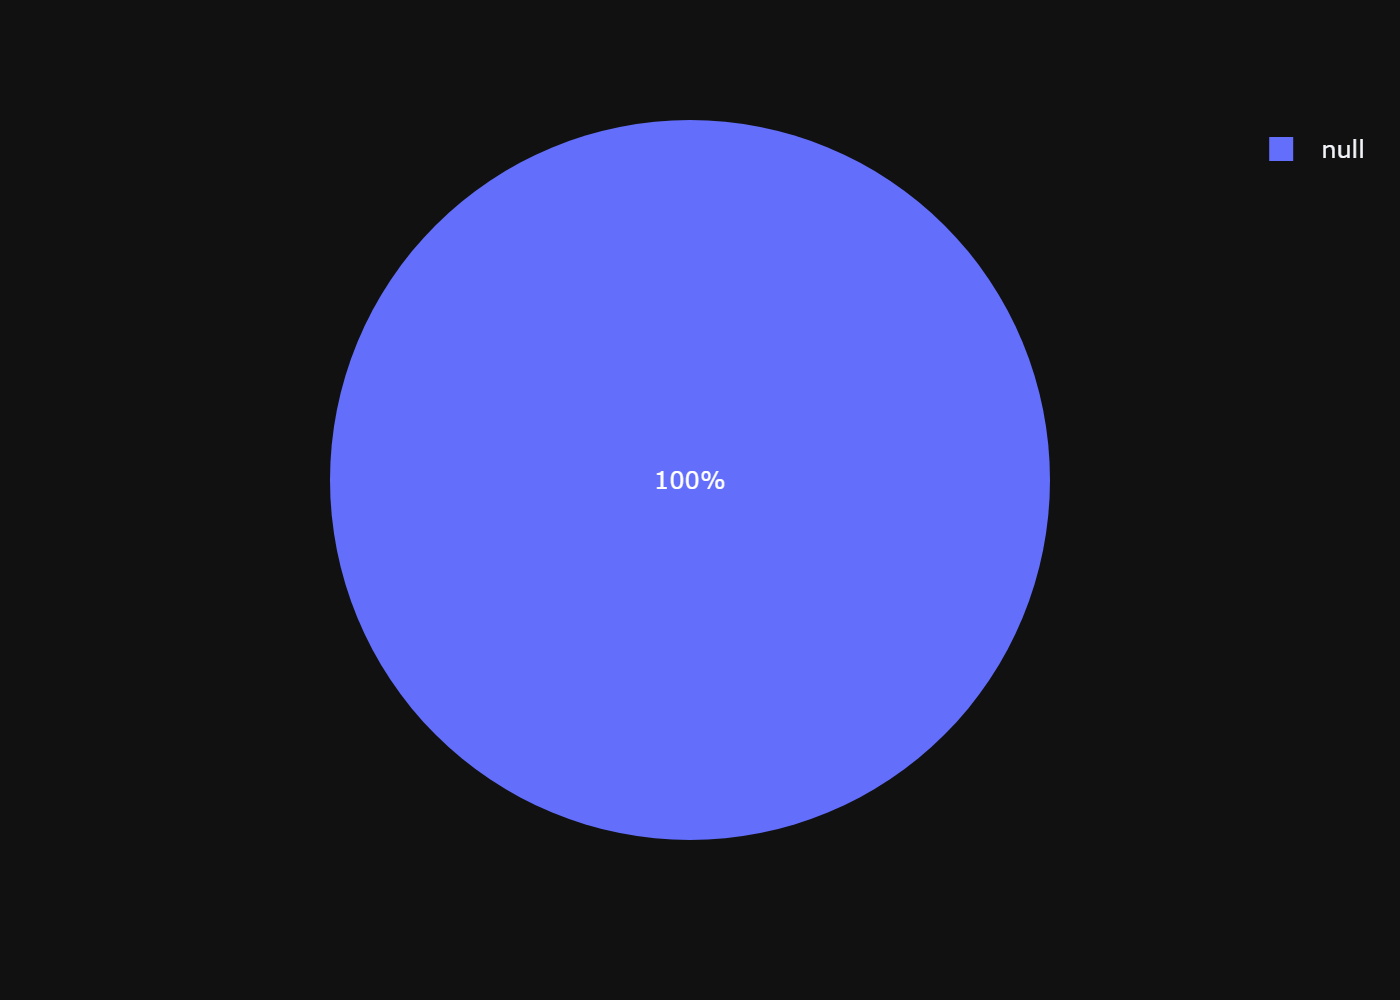

('SELECT SUM("Total Amount") AS Total_Sales_2019\nFROM retail_sales\nWHERE strftime(\'%Y\', "Date") = \'2019\';',
   Total_Sales_2019
 0             None,
 Figure({
     'data': [{'domain': {'x': [0.0, 1.0], 'y': [0.0, 1.0]},
               'hovertemplate': 'Total_Sales_2019=%{label}<extra></extra>',
               'labels': array([None], dtype=object),
               'legendgroup': '',
               'name': '',
               'showlegend': True,
               'type': 'pie'}],
     'layout': {'legend': {'tracegroupgap': 0}, 'margin': {'t': 60}, 'template': '...'}
 }))

In [6]:
query_res = vn.ask('What is the total sales for the year 2019?')
query_res

In [10]:
# [
#   {
#     "role": "system",
#     "content": "You are a SQLite expert. Please help to generate a SQL query to answer the question. \
#     Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \
#     ===Response Guidelines\n \
#     1. If the provided context is sufficient, please generate a valid SQL query without any explanations for the question.\n \
#     2. If the provided context is almost sufficient but requires knowledge of a specific string in a particular column, please generate an intermediate SQL query to find the distinct strings in that column. \
#     Prepend the query with a comment saying intermediate_sql\n \
#     3. If the provided context is insufficient, please explain why it can't be generated.\n \
#     4. Please use the most relevant table(s).\n \
#     5. If the question has been asked and answered before, please repeat the answer exactly as it was given before.\n \
#     6. Ensure that the output SQL is SQLite-compliant and executable, and free of syntax errors.\n"
#   },
#   {
#     "role": "user",
#     "content": "What is the total sales for the year 2019?"
#   }
# ]

### Training model

In [11]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

for ddl in df_ddl['sql'].to_list():
  vn.train(ddl=ddl)

Add of existing embedding ID: c0722b1a-9219-5821-a433-1ae5856d8f80-ddl
Insert of existing embedding ID: c0722b1a-9219-5821-a433-1ae5856d8f80-ddl


Adding ddl: CREATE TABLE "retail_sales" (
"Transaction ID" INTEGER,
  "Date" TEXT,
  "Customer ID" TEXT,
  "Gender" TEXT,
  "Age" INTEGER,
  "Product Category" TEXT,
  "Quantity" INTEGER,
  "Price per Unit" INTEGER,
  "Total Amount" INTEGER
)


In [12]:
# Sometimes you may want to add documentation about your business terminology or definitions.
vn.train(documentation="The 'retail_sales' table contains the sales data for a retail store.")


Adding documentation....


Add of existing embedding ID: 64ef8c4a-13f1-5770-b50e-539607aa561d-doc


Insert of existing embedding ID: 64ef8c4a-13f1-5770-b50e-539607aa561d-doc


'64ef8c4a-13f1-5770-b50e-539607aa561d-doc'

In [7]:
# At any time you can inspect what training data the package is able to reference
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type
0,2d55e3f1-a6dc-535b-a8d4-79c7dcabc9c6-sql,What is the total sales for the year 2019?,"SELECT SUM(""Total Amount"") AS Total_Sales_2019...",sql
1,e0849d09-0149-58de-9991-4b8e537ca204-sql,what is the average price of beauty,"SELECT AVG(""Price per Unit"") AS Average_Beauty...",sql
2,259649f1-3d87-55bd-bc1e-f8c56c955a61-sql,What is the total sales amount for the dataset?,"SELECT \n ""Product Category"", \n AVG(""Price ...",sql
3,3797feb8-adb8-5ef9-ae66-facff8c2882b-sql,What is the total sales amount for the dataset?,"SELECT ""Age"", SUM(""Total Amount"") AS Total_Spe...",sql
4,aca54d81-9b8a-57f6-8ab3-439b5e3f46e8-sql,What is the total sales amount for the dataset?,"SELECT \n ""Gender"", \n ""Product Category"", \...",sql
5,a3a94036-d4b3-5747-8849-a7e7b78d889a-sql,What is the total sales amount for the dataset?,"SELECT \n ""Gender"", \n ""Product Category"", \...",sql
6,79445553-f3fe-563d-8e26-b5b8243c38d9-sql,What is the total sales amount for the dataset?,"SELECT \n ""Product Category"", \n SUM(""Quanti...",sql
0,c0722b1a-9219-5821-a433-1ae5856d8f80-ddl,None,"CREATE TABLE ""retail_sales"" (\n""Transaction ID...",ddl
0,64ef8c4a-13f1-5770-b50e-539607aa561d-doc,None,The 'retail_sales' table contains the sales da...,documentation


In [14]:
# # You can remove training data if there's obsolete/incorrect information. 
# vn.remove_training_data(id='1-ddl')


In [ ]:
from vanna.flask import VannaFlaskApp
app = VannaFlaskApp(vn)
app.run()

Your app is running at:
http://localhost:8084
 * Serving Flask app 'vanna.flask'
 * Debug mode: on


Number of requested results 10 is greater than number of elements in index 7, updating n_results = 7
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1


Using model gpt-4o for 678.5 tokens (approx)
